In [2]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)

os.environ["WANDB_DISABLED"] = "true"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


## Dataset Loader

In [6]:
class TextTensorDataset(Dataset):
    def __init__(self, tensor_dict):
        self.input_ids = tensor_dict["input_ids"]
        self.attention_mask = tensor_dict["attention_mask"]
        self.labels = tensor_dict["labels"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }


def load_text_data_kaggle(model_name):
    base = "/kaggle/input/train-test-val-data-of-different-transformer-model/textdata_large(9k)"
    train = torch.load(f"{base}/train_tensors_{model_name}.pt")
    val   = torch.load(f"{base}/val_tensors_{model_name}.pt")
    test  = torch.load(f"{base}/test_tensors_{model_name}.pt")

    return (
        TextTensorDataset(train),
        TextTensorDataset(val),
        TextTensorDataset(test)
    )


## Check for exact overlap between train / val / test

In [7]:
import hashlib

def hash_sample(input_ids, attention_mask):
    h = hashlib.sha256()
    h.update(input_ids.cpu().numpy().tobytes())
    h.update(attention_mask.cpu().numpy().tobytes())
    return h.hexdigest()

def dataset_hashes(dataset):
    return {
        hash_sample(dataset.input_ids[i], dataset.attention_mask[i])
        for i in range(len(dataset))
    }


In [8]:
train_ds, val_ds, test_ds = load_text_data_kaggle("bert-base-multilingual-uncased")

train_hashes = dataset_hashes(train_ds)
val_hashes   = dataset_hashes(val_ds)
test_hashes  = dataset_hashes(test_ds)

print("Train ∩ Val :", len(train_hashes & val_hashes))
print("Train ∩ Test:", len(train_hashes & test_hashes))
print("Val ∩ Test  :", len(val_hashes & test_hashes))


Train ∩ Val : 0
Train ∩ Test: 0
Val ∩ Test  : 0


## Check for duplicated samples within each split

In [9]:
def count_duplicates(dataset):
    hashes = [
        hash_sample(dataset.input_ids[i], dataset.attention_mask[i])
        for i in range(len(dataset))
    ]
    return len(hashes) - len(set(hashes))


In [10]:
print("Train duplicates:", count_duplicates(train_ds))
print("Val duplicates  :", count_duplicates(val_ds))
print("Test duplicates :", count_duplicates(test_ds))


Train duplicates: 147
Val duplicates  : 26
Test duplicates : 15


removing them is optional and won’t meaningfully affect performance.

## Metrics + Plots

### Trainer Metrics

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_text_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        p.label_ids, preds, average="binary", zero_division=0
    )
    acc = accuracy_score(p.label_ids, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


### Confusion Matrix

In [12]:
def plot_confusion_matrix(trainer, dataset, model_name):
    preds = trainer.predict(dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Fake", "Real"])

    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.show()


### ROC Curve

In [13]:
def plot_roc_curve(trainer, dataset, model_name):
    preds = trainer.predict(dataset)

    y_true = preds.label_ids
    y_scores = torch.softmax(
        torch.tensor(preds.predictions), dim=1
    )[:, 1].numpy()

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {model_name}")
    plt.legend()
    plt.show()


## Fusion-Ready Model Saving

In [14]:
def save_text_model_for_fusion(trainer, model_name):
    save_dir = f"/kaggle/working/fusion_text_models/{model_name}"
    os.makedirs(save_dir, exist_ok=True)

    # Save full HF model (encoder + classifier)
    trainer.model.save_pretrained(save_dir)

    # Save tokenizer
    trainer.tokenizer.save_pretrained(save_dir)

    # Safety note
    with open(os.path.join(save_dir, "FUSION_README.txt"), "w") as f:
        f.write(
            "Load with:\n"
            "AutoModelForSequenceClassification.from_pretrained(\n"
            "  path,\n"
            "  output_hidden_states=True\n"
            ")"
        )

    print(f"✅ Fusion-ready model saved → {save_dir}")

## Evaluate

In [15]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def print_evaluation_results(trainer, dataset, model_name):
    predictions = trainer.predict(dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    print(f"\n===== Evaluation Results: {model_name} =====")
    print(f"Accuracy            : {acc:.4f}\n")

    # Macro Avg
    print("Macro Average")
    print(f"  Precision         : {report['macro avg']['precision']:.4f}")
    print(f"  Recall            : {report['macro avg']['recall']:.4f}")
    print(f"  F1-score          : {report['macro avg']['f1-score']:.4f}\n")

    # Micro Avg (same as accuracy in binary classification)
    print("Micro Average")
    print(f"  Precision         : {acc:.4f}")
    print(f"  Recall            : {acc:.4f}")
    print(f"  F1-score          : {acc:.4f}\n")

    # Weighted Avg
    print("Weighted Average")
    print(f"  Precision         : {report['weighted avg']['precision']:.4f}")
    print(f"  Recall            : {report['weighted avg']['recall']:.4f}")
    print(f"  F1-score          : {report['weighted avg']['f1-score']:.4f}")
    print("========================================\n")


## Training Function

In [16]:
def train_text_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2
    )

    train_ds, val_ds, test_ds = load_text_data_kaggle(model_name)

    args = TrainingArguments(
        output_dir=f"/kaggle/working/checkpoints/{model_name}",
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=50,
        save_total_limit=1,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_text_metrics
    )

    trainer.train()
    return trainer, test_ds


## Multiple model

In [ ]:
MODEL_NAME = "xlm-roberta-base"

trainer, test_ds = train_text_model(MODEL_NAME)

print_evaluation_results(trainer, test_ds, MODEL_NAME)
plot_confusion_matrix(trainer, test_ds, MODEL_NAME)
plot_roc_curve(trainer, test_ds, MODEL_NAME)

save_text_model_for_fusion(trainer, MODEL_NAME)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/4231125517.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,0.484800
100,0.280000
150,0.198100
200,0.138600
250,0.126800
300,0.091700
350,0.066300
400,0.078000
450,0.043500
500,0.042000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



===== Evaluation Results: bert-base-multilingual-uncased =====
Accuracy            : 0.9695

Macro Average
  Precision         : 0.9684
  Recall            : 0.9708
  F1-score          : 0.9693

Micro Average
  Precision         : 0.9695
  Recall            : 0.9695
  F1-score          : 0.9695

Weighted Average
  Precision         : 0.9701
  Recall            : 0.9695
  F1-score          : 0.9696



/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


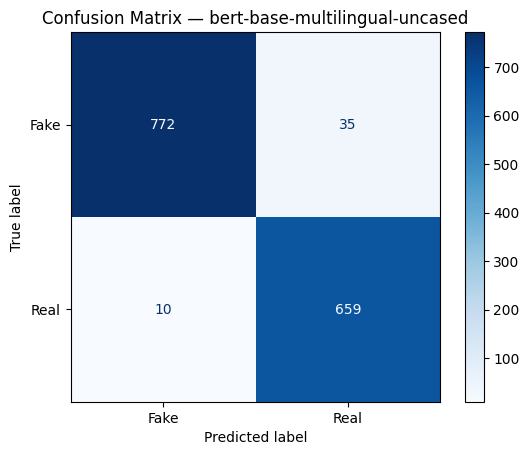

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


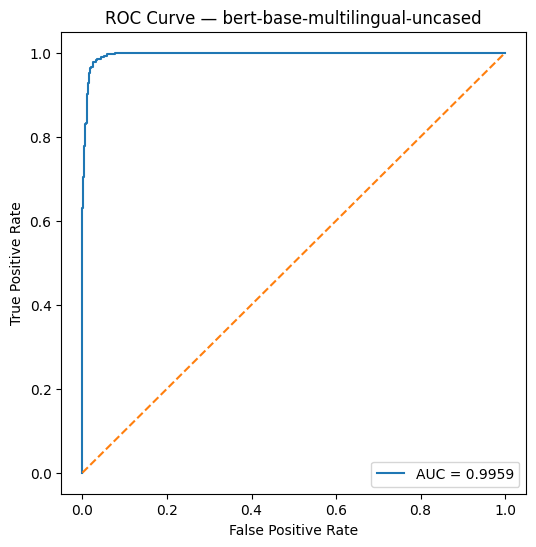

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


✅ Fusion-ready model saved → /kaggle/working/fusion_text_models/bert-base-multilingual-uncased


In [19]:
MODEL_NAME = "bert-base-multilingual-uncased"

trainer, test_ds = train_text_model(MODEL_NAME)

print_evaluation_results(trainer, test_ds, MODEL_NAME)
plot_confusion_matrix(trainer, test_ds, MODEL_NAME)
plot_roc_curve(trainer, test_ds, MODEL_NAME)

save_text_model_for_fusion(trainer, MODEL_NAME)

In [ ]:
MODEL_NAME = "bert-base-multilingual-cased"

trainer, test_ds = train_text_model(MODEL_NAME)

print_evaluation_results(trainer, test_ds, MODEL_NAME)
plot_confusion_matrix(trainer, test_ds, MODEL_NAME)
plot_roc_curve(trainer, test_ds, MODEL_NAME)

save_text_model_for_fusion(trainer, MODEL_NAME)

In [ ]:
MODEL_NAME = "distilbert-base-multilingual-cased"

trainer, test_ds = train_text_model(MODEL_NAME)

print_evaluation_results(trainer, test_ds, MODEL_NAME)
plot_confusion_matrix(trainer, test_ds, MODEL_NAME)
plot_roc_curve(trainer, test_ds, MODEL_NAME)

save_text_model_for_fusion(trainer, MODEL_NAME)

In [ ]:
import shutil

shutil.make_archive('/kaggle/working/fusion_text_models', 'zip', '/kaggle/working/fusion_text_models')


In [ ]:
shutil.make_archive('/kaggle/working/checkpoints', 'zip', '/kaggle/working/checkpoints')

In [ ]:
import shutil
import os

dir_path = "/kaggle/working/checkpoints_backup.zip"

if os.path.exists(file_path):
    os.remove(file_path)
    print("File removed")
else:
    print("File not found")


In [ ]:
import os

path = "/kaggle/working/checkpoints/bert-base-multilingual-uncased"

if os.path.exists(path):
    for item in os.listdir(path):
        print(item)
else:
    print("Folder does not exist")


In [ ]:
import shutil
import os

folder_path = "/kaggle/working/checkpoints/bert-base-multilingual-uncased"
zip_path = "/kaggle/working/checkpoints_backup"

if os.path.exists(folder_path):
    shutil.make_archive(zip_path, 'zip', folder_path)
    print("Folder zipped successfully")
else:
    print("Folder does not exist")


In [ ]:
from IPython.display import FileLink

# Make sure path matches exactly
zip_path = "/kaggle/working/checkpoints_backup.zip"

# Display clickable download link
display(FileLink(zip_path))